> Auto-differentiable DRR rendering and optimization in PyTorch

[![CI](https://github.com/eigenvivek/DiffDRR/actions/workflows/test.yaml/badge.svg)](https://github.com/eigenvivek/DiffDRR/actions/workflows/test.yaml)
[![Paper shield](https://img.shields.io/badge/arXiv-2208.12737-red.svg)](https://arxiv.org/abs/2208.12737)
[![License: MIT](https://img.shields.io/badge/License-MIT-blue.svg)](LICENSE)
[![Downloads](https://static.pepy.tech/personalized-badge/diffdrr?period=total&units=none&left_color=grey&right_color=blue&left_text=downloads)](https://pepy.tech/project/diffdrr)
[![Docs](https://github.com/eigenvivek/DiffDRR/actions/workflows/deploy.yaml/badge.svg)](https://vivekg.dev/DiffDRR/)
[![Code style: black](https://img.shields.io/badge/Code%20style-black-black.svg)](https://github.com/psf/black)

`DiffDRR` is a PyTorch-based digitally reconstructed radiograph (DRR) generator that provides

1. Differentiable X-ray rendering
2. GPU-accelerated synthesis and optimization
3. A pure Python implementation

Most importantly, `DiffDRR` implements DRR rendering as a PyTorch module, making it interoperable in deep learning pipelines.

## Install

To install the latest stable release (**recommended**):

```zsh
pip install diffdrr
```

To install the development version:

```zsh
git clone https://github.com/eigenvivek/DiffDRR.git --depth 1
pip install -e 'DiffDRR/[dev]'
```

## Hello, World!

The following minimal example specifies the geometry of the projectional radiograph imaging system and traces rays through a CT volume:

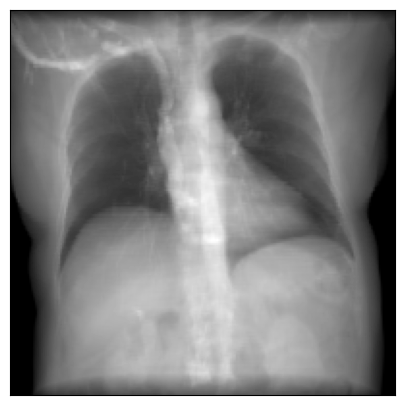

In [ ]:
import matplotlib.pyplot as plt
import torch

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.visualization import plot_drr

# Read in the volume and get its origin and spacing in world coordinates
subject = load_example_ct()

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(
    subject,     # An object storing the CT volume, origin, and voxel spacing
    sdd=1020.0,  # Source-to-detector distance (i.e., focal length)
    height=200,  # Image height (if width is not provided, the generated DRR is square)
    delx=2.0,    # Pixel spacing (in mm).
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[0.0, 0.0, 0.0]], device=device)
translations = torch.tensor([[0.0, 850.0, 0.0]], device=device)

# 📸 Also note that DiffDRR can take many representations of SO(3) 📸
# For example, quaternions, rotation matrix, axis-angle, etc...
img = drr(rotations, translations, parameterization="euler_angles", convention="ZXY")
plot_drr(img, ticks=False)
plt.show()

On a single NVIDIA RTX 2080 Ti GPU, producing such an image takes

In [ ]:
# |code-fold: false
%timeit drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

25.2 ms ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The full example is available at [`introduction.ipynb`](https://vivekg.dev/DiffDRR/tutorials/introduction.html).

## Usage

### Rendering

The physics-based pipeline in `DiffDRR` renders photorealistic X-rays. For example, compare 
a real X-ray to a synthetic X-ray rendered from a CT of the same patient using `DiffDRR`
(X-rays and CTs from the [DeepFluoro dataset](https://github.com/rg2/DeepFluoroLabeling-IPCAI2020)):

![`DiffDRR` rendering from the same camera pose as a real X-ray.](https://cdn.githubraw.com/eigenvivek/DiffDRR/main/notebooks/index_files/deepfluoro.png)

### 2D/3D Registration

The impotus for developing `DiffDRR` was to solve 2D/3D registration
problems with gradient-based optimization. Here, we demonstrate `DiffDRR`'s
capabilities by generating two DRRs:

1.  A fixed DRR from a set of ground truth parameters
2.  A moving DRR from randomly initialized parameters

To align the two images, we use gradient descent to maximize
an image similarity metric between the two DRRs. This produces
optimization runs like this:

![Iterative optimization of moving DRR to a target DRR.](https://cdn.githubraw.com/eigenvivek/DiffDRR/main/experiments/registration.gif)

The full example is available at
[`optimizers.ipynb`](https://vivekg.dev/DiffDRR/tutorials/optimizers.html)

#### *🆕 Examples on Real-World Data 🆕*

For examples running `DiffDRR` on real surgical datasets, check out our latest work, [`DiffPose`](https://github.com/eigenvivek/DiffPose):

![Registering real X-rays to real CT scans.](https://cdn.githubraw.com/eigenvivek/DiffPose/main/experiments/test_time_optimization.gif)

This work includes a lot of real-world usecases of `DiffDRR` including

- Using `DiffDRR` as a layer in a deep learning architecture
- Alignment of real X-rays and rendered DRRs
- Achieving sub-millimeter registration accuracy very quickly

### Segmentation

`DiffDRR` can project 3D labelmaps into 2D simply using perspective geometry, helping identify particular structures in simulated X-rays
(these labels come from the [TotalSegmentator v2 dataset](https://github.com/wasserth/TotalSegmentator)):

![Projected segmentation masks.](https://cdn.githubraw.com/eigenvivek/DiffDRR/main/notebooks/index_files/segmentation.png)

### Volume Reconstruction

`DiffDRR` is differentiable with respect to the 3D volume as well as camera poses.
Therefore, it can be used for volume reconstruction via differentiable
rendering (see [`reconstruction.ipynb`](https://vivekg.dev/DiffDRR/tutorials/reconstruction.html))!

#### *🆕 Examples on Real-World Data 🆕*

For an in-depth example using `DiffDRR` for cone-beam CT reconstruction, check out [`DiffVox`](https://github.com/hossein-momeni/DiffVox).

## Development

> **TLDR:** Source code is stored in `notebooks/api/`, not `diffdrr/`. Update the notebooks instead!

`DiffDRR` source code, docs, and CI are all built using
[`nbdev`](https://nbdev.fast.ai/). To get set up with `nbdev`, install
the following

``` zsh
mamba install jupyterlab nbdev -c fastai -c conda-forge 
nbdev_install_quarto  # To build docs
nbdev_install_hooks   # Make notebooks git-friendly
```

Running `nbdev_help` will give you the full list of options. The most
important ones are

``` zsh
nbdev_preview  # Render docs locally and inspect in browser
nbdev_clean    # NECESSARY BEFORE PUSHING
nbdev_test     # tests notebooks
nbdev_export   # builds package and builds docs
```

For more details, follow this [in-depth
tutorial](https://nbdev.fast.ai/tutorials/tutorial.html).

## How does `DiffDRR` work?

`DiffDRR` reformulates Siddon's method,[^1] the canonical algorithm for calculating the radiologic path of an X-ray through a volume, as a series of vectorized tensor operations. This version of the algorithm is easily implemented in tensor algebra libraries like PyTorch to achieve a fast auto-differentiable DRR generator.

[^1]: [Siddon RL. Fast calculation of the exact radiological path for a three-dimensional CT array.
Medical Physics, 2(12):252–5, 1985.](https://doi.org/10.1118/1.595715)

## Citing `DiffDRR`

If you find `DiffDRR` useful in your work, please cite our
[paper](https://arxiv.org/abs/2208.12737):

    @inproceedings{gopalakrishnan2022fast,
      title={Fast auto-differentiable digitally reconstructed radiographs for solving inverse problems in intraoperative imaging},
      author={Gopalakrishnan, Vivek and Golland, Polina},
      booktitle={Workshop on Clinical Image-Based Procedures},
      pages={1--11},
      year={2022},
      organization={Springer}
    }

If the 2D/3D registration capabilities are helpful, please cite our followup, [`DiffPose`](https://arxiv.org/abs/2312.06358):

    @article{gopalakrishnan2023intraoperative,
      title={Intraoperative {2D/3D} image registration via differentiable {X}-ray rendering},
      author={Gopalakrishnan, Vivek and Dey, Neel and Golland, Polina},
      booktitle={Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition},
      pages={11662--11672},
      year={2024}
    }

If you use the 3D CBCT reconstruction capabilities, please cite our followup, [`DiffVox`](https://arxiv.org/abs/2411.19224):

    @article{momeni2024voxel,
      title={Voxel-based Differentiable X-ray Rendering Improves Self-Supervised 3D CBCT Reconstruction},
      author={Momeni, Mohammadhossein and Gopalakrishnan, Vivek and Dey, Neel and Golland, Polina and Frisken, Sarah},
      booktitle={Machine Learning and the Physical Sciences, NeurIPS 2024},
      year={2024}
    }